# Part 2. Sentence-Level Categorization: Question Classification

In [3]:
!pip install -U scikit-learn scipy matplotlib

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 60.4/60.4 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------- ----------------------------- 2.4/9.3 MB 50.1 MB/s eta 0:00:01
   ------------------------- -------------- 5.8/9.3 MB 74.7 MB/s eta 0:00:01
   ---------------------------------------  9.2/9.3 MB 73.9 MB/s eta 0:00:01
   ---------------------------------------- 9.3/9.3 MB 53.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/44.1 MB ? eta -:--:--
   - -------------------------------------- 2.1/44.1 MB 43.8 MB/s eta 0:00:01
   ----- ---------------------------------- 6.6/44.1 MB 69.8 MB/s eta 0:00:01
   ---------- ----------------------------- 11.3/44.1 MB 93.9 MB/s eta 0:00:01
   ------------ --------------------------- 13.6/44.1 MB 93.0 MB/s eta 0:00:01
   -------------- ------------------------- 16.3/44.1 MB 65.6 MB/s eta 0:00:01
   -----

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [84]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Embedding, Reshape, GlobalMaxPooling1D, Bidirectional, Dropout, Lambda
from tensorflow.keras.layers import LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Multiply
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LambdaCallback

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
import gensim.downloader

In [85]:
if tf.config.experimental.list_physical_devices('GPU'):
    device = "cuda"
elif tf.config.experimental.list_physical_devices('MPS_GPU'):
    device = "mps"
else:
    device = "cpu"
print(f"Using {device} device")

Using cpu device


In [86]:
w2v = gensim.downloader.load('word2vec-google-news-300')

### 2.1 Preprocess datset
- Includes training, development, test file
- Form a random subset of 500 samples from training file to create development file (& remove them from the latter)

In [77]:
df = pd.read_csv('./archive/train.csv')
df_test = pd.read_csv('./archive/test.csv')

# Clean dataset
# Remove unecessary whitespacing and characters not in the English language
def text_preprocessing(df):
    df['text'] = df['text'].str.replace("[^A-Za-z]", " ", regex=True)
    df['text'] = df['text'].str.replace("\s+", " ", regex=True)
    return df

df_train, df_test = text_preprocessing(df), text_preprocessing(df_test)

df_train = df.drop('label-fine', axis=1)
df_test = df_test.drop('label-fine', axis=1)


# Extract 500 samples from df
df_dev = df_train.sample(n=500, random_state=1)
df_train = df_train.drop(df_dev.index, axis=0)
df_train.reset_index(drop=True, inplace=True)

display(df_train.head(5))
display(df_test.head(5))
print(f'df_train.shape: {df_train.shape},\ndf_dev.shape: {df_dev.shape},\ndf_test.shape: {df_test.shape}')

,label-coarse,text
0,0,How did serfdom develop in and then leave Russia
1,1,What films featured the character Popeye Doyle
2,0,How can I find a list of celebrities real names
3,1,What fowl grabs the spotlight after the Chines...
4,3,What team did baseball s St Louis Browns become


,label-coarse,text
0,4,How far is it from Denver to Aspen
1,5,What county is Modesto California in
2,3,Who was Galileo
3,0,What is an atom
4,4,When did Hawaii become a state


df_train.shape: (4952, 2),
df_dev.shape: (500, 2),
df_test.shape: (500, 2)


### 2.2 Combine coarse labels into 5 classes

- Randomly select 4 classes from 6 coarse labels, and combine the remaining 2 labels to form a single class: 'OTHERS'.

There are 6 classes in column df['label-coarse']. Randomly choose 4 classes and merge the other two into 'OTHERS' class. The final 5 classes must have values ranged from 0,1,2,3,4. If there is any class with number greater than 4, map it to a number that is not taken by the other classes. In the end, denote which number this 'OTHERS' class is mapped to.

In [83]:
def transform_labels(df_train, df_dev, df_test):
    labels = [0, 1, 2, 3, 4, 5]
    random.shuffle(labels)
    
    # Take the last two labels to be merged into 'OTHERS'
    OTHERS_label = labels[-2:]
    print(f"{labels[-2],labels[-1]} is mapped to 'OTHERS'")
    
    # Function to apply the transformations to a dataframe as well as remapping of labels
    def apply_transformations(df, used_labels, OTHERS_label, unused_labels):
        df['label-coarse'] = df['label-coarse'].replace(OTHERS_label, 'OTHERS')
        for label in used_labels:
            if label > 4:
                df['label-coarse'] = df['label-coarse'].replace(label, unused_labels[0])
                used_labels.append(unused_labels[0])
                unused_labels = unused_labels[1:]

        df['label-coarse'] = df['label-coarse'].replace('OTHERS', unused_labels[-1])
        return df
    
    # Determine the unused labels and 'OTHERS' label for df_train
    used_labels = [label for label in labels if label not in OTHERS_label]
    unused_labels = [x for x in range(5) if x not in used_labels]

    df_train = apply_transformations(df_train, used_labels, OTHERS_label, unused_labels)
    df_dev = apply_transformations(df_dev, used_labels, OTHERS_label, unused_labels)
    df_test = apply_transformations(df_test, used_labels, OTHERS_label, unused_labels)

    if 5 in used_labels:
        print(f"5 is now mapped to {unused_labels[0]}")
    print(f"'OTHERS' label is mapped to: {unused_labels[-1]}")
    return df_train, df_dev, df_test

print(f"df_train:\n{df_train['label-coarse'].value_counts()}\n")
print(f"df_dev:\n{df_dev['label-coarse'].value_counts()}\n")
print(f"df_test:\n{df_test['label-coarse'].value_counts()}")

transform_labels(df_train, df_dev, df_test)

print(f"df_train:\n{df_train['label-coarse'].value_counts()}\n")
print(f"df_dev:\n{df_dev['label-coarse'].value_counts()}\n")
print(f"df_test:\n{df_test['label-coarse'].value_counts()}")

df_train:
3    1181
1    1144
0    1056
4     811
2     760
Name: label-coarse, dtype: int64

df_dev:
3    128
0    106
1    106
4     85
2     75
Name: label-coarse, dtype: int64

df_test:
0    138
4    113
1     94
2     81
3     74
Name: label-coarse, dtype: int64
(3, 2) is mapped to 'OTHERS'
5 is now mapped to 2
'OTHERS' label is mapped to: 3
df_train:
3    1941
1    1144
0    1056
4     811
Name: label-coarse, dtype: int64

df_dev:
3    203
0    106
1    106
4     85
Name: label-coarse, dtype: int64

df_test:
3    155
0    138
4    113
1     94
Name: label-coarse, dtype: int64


### 2.3 Use pretrained word embeddings from Section 1.1 as inputs
- Do not update them

In [79]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])
X_train = tokenizer.texts_to_sequences(df_train['text'])
X_val = tokenizer.texts_to_sequences(df_dev['text'])
X_test = tokenizer.texts_to_sequences(df_test['text'])

# Pad the sentences to the same length
# max_length = max([len(seq) for seq in X_train])
max_length = 33
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post')

y_train = df_train['label-coarse'].values
y_val = df_dev['label-coarse'].values
y_test = df_test['label-coarse'].values

### 2.4 Design a neural network
- Transform the input for each word into its final vector representation
- Aggregate the word vectors into the softmax classifier to predict the final label for each questions
- Choose to use LSTM model

In [80]:
embedding_dim = 300
hidden_units = 64 # LSTM
num_classes = 5
batch_size = 64
num_epochs = 50
labels = [0, 1, 2, 3, 4]
vocab_size = len(tokenizer.word_index) + 1

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# Implement early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 300)           2317500   
                                                                 
 dropout (Dropout)           (None, 33, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 2411265 (9.20 MB)
Trainable params: 2411265 (9.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### 2.5 Use mini-batch strategy during training
- Choose 'Adam' optimizer
- Learning rate = 0.001

In [81]:
hist = model.fit(
    X_train_padded, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_padded, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

Epoch 1/50
78/78 [==============================] - 18s 138ms/step - loss: 1.5975 - accuracy: 0.2286 - val_loss: 1.5913 - val_accuracy: 0.2560
Epoch 2/50
78/78 [==============================] - 10s 134ms/step - loss: 1.3260 - accuracy: 0.3770 - val_loss: 1.2799 - val_accuracy: 0.3900
Epoch 3/50
78/78 [==============================] - 11s 143ms/step - loss: 0.9653 - accuracy: 0.5230 - val_loss: 1.1250 - val_accuracy: 0.4920
Epoch 4/50
78/78 [==============================] - 11s 144ms/step - loss: 0.7051 - accuracy: 0.6511 - val_loss: 0.8874 - val_accuracy: 0.6520
Epoch 5/50
78/78 [==============================] - 11s 140ms/step - loss: 0.5255 - accuracy: 0.7490 - val_loss: 0.7851 - val_accuracy: 0.6660
Epoch 6/50
78/78 [==============================] - 11s 135ms/step - loss: 0.4105 - accuracy: 0.8391 - val_loss: 0.7937 - val_accuracy: 0.7200
Epoch 7/50
78/78 [==============================] - 10s 134ms/step - loss: 0.2617 - accuracy: 0.9162 - val_loss: 0.7907 - val_accuracy: 0.7860

### 2.6 Evaluate the model
- Use accuracy to measure perfomance for each epoch during training

16/16 [==============================] - 1s 23ms/step


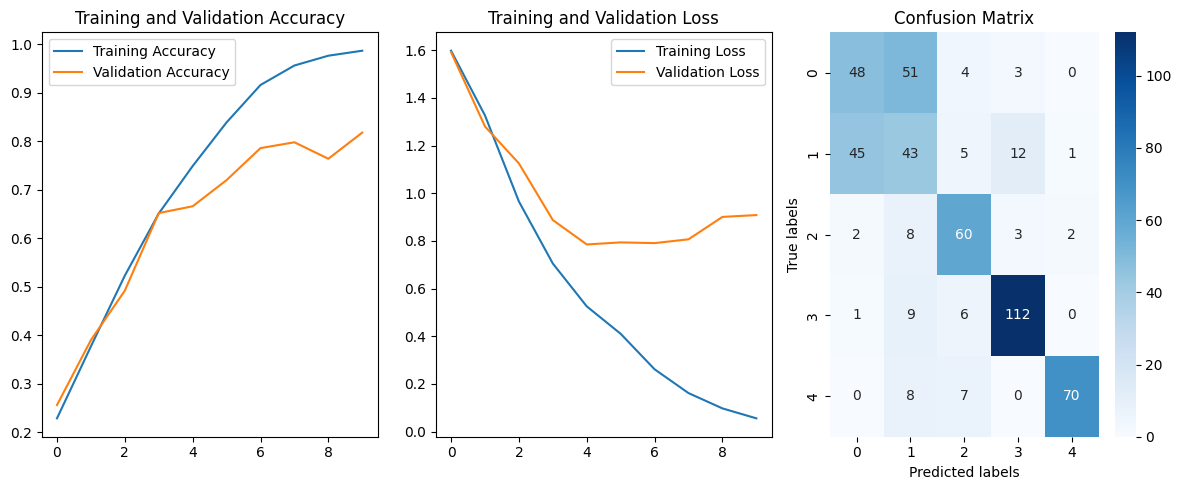

In [82]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')


y_pred = np.argmax(model.predict(X_val_padded), axis=1)
cm = confusion_matrix(y_val, y_pred)
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

In [10]:
_, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

f1_micro = f1_score(y_val, y_pred, average='micro')
print(f"f1_score: {f1_micro:.4f}")

16/16 [==============================] - 0s 6ms/step - loss: 0.7243 - accuracy: 0.7900
Test Accuracy: 79.00%
f1_score: 0.7900


### 2.7.1 Create more complex network in model2
Add the following layers to the model:
- Bidirectional layer
- Batch normalisation layer

### 2.7.2 Training model2 with optimal hyperparameters

In [118]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)
    ),
    tf.keras.layers.LSTM(hidden_units, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 33, 300)           2317500   
                                                                 
 dropout_37 (Dropout)        (None, 33, 300)           0         
                                                                 
 bidirectional_24 (Bidirect  (None, 33, 128)           186880    
 ional)                                                          
                                                                 
 lstm_59 (LSTM)              (None, 64)                49408     
                                                                 
 batch_normalization_29 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_60 (Dense)            (None, 5)               

In [119]:
hist2 = model2.fit(
    X_train_padded, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_padded, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

Epoch 1/50
78/78 [==============================] - 14s 137ms/step - loss: 1.5695 - accuracy: 0.2847 - val_loss: 1.5130 - val_accuracy: 0.2840
Epoch 2/50
78/78 [==============================] - 12s 156ms/step - loss: 1.4124 - accuracy: 0.3314 - val_loss: 1.4611 - val_accuracy: 0.2500
Epoch 3/50
78/78 [==============================] - 13s 166ms/step - loss: 1.4099 - accuracy: 0.3376 - val_loss: 1.4071 - val_accuracy: 0.3220
Epoch 4/50
78/78 [==============================] - 13s 167ms/step - loss: 1.4001 - accuracy: 0.3296 - val_loss: 1.3967 - val_accuracy: 0.3160
Epoch 5/50
78/78 [==============================] - 13s 164ms/step - loss: 1.4157 - accuracy: 0.3176 - val_loss: 1.3820 - val_accuracy: 0.3520
Epoch 6/50
78/78 [==============================] - 13s 168ms/step - loss: 1.4001 - accuracy: 0.3231 - val_loss: 1.3792 - val_accuracy: 0.3320
Epoch 7/50
78/78 [==============================] - 13s 169ms/step - loss: 1.3839 - accuracy: 0.3407 - val_loss: 1.2801 - val_accuracy: 0.4500

16/16 [==============================] - 0s 12ms/step


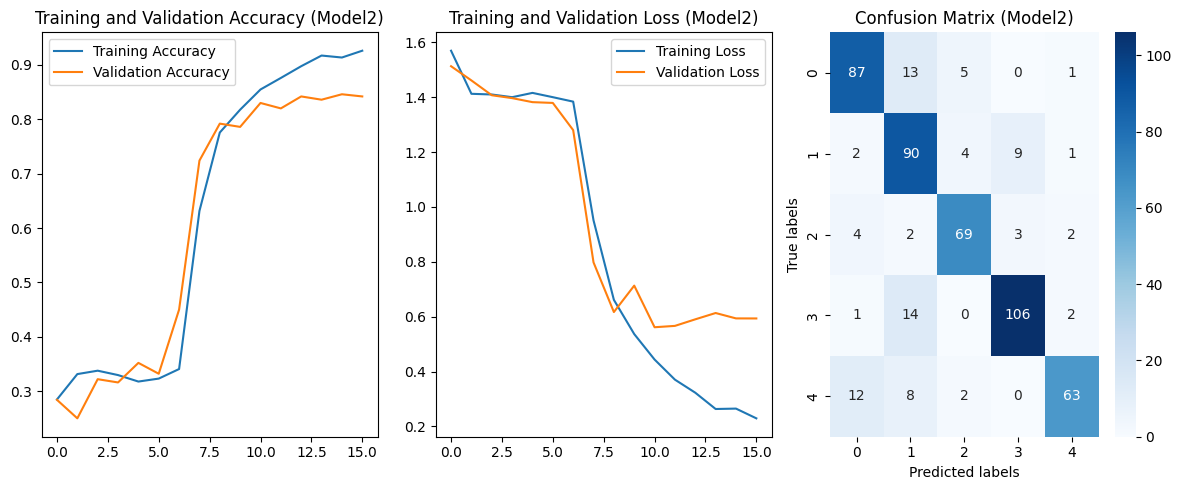

In [132]:
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Model2)')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Model2)')


y_pred2 = np.argmax(model2.predict(X_val_padded), axis=1)
cm = confusion_matrix(y_val, y_pred2)
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Model2)')

plt.tight_layout()
plt.show()

### 2.8 Try aggregation methods

In [120]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v:  # Check if the word is in the Word2Vec model
        embedding_vector = w2v[word]
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False
)

In [121]:
modelAve = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)
    ),
    tf.keras.layers.LSTM(hidden_units, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
modelAve.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(modelAve.summary())


histAve = modelAve.fit(
    X_train_padded,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_padded, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 33, 300)           2317500   
                                                                 
 dropout_38 (Dropout)        (None, 33, 300)           0         
                                                                 
 bidirectional_25 (Bidirect  (None, 33, 128)           186880    
 ional)                                                          
                                                                 
 lstm_61 (LSTM)              (None, 64)                49408     
                                                                 
 batch_normalization_30 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_61 (Dense)            (None, 5)               

16/16 [==============================] - 0s 12ms/step


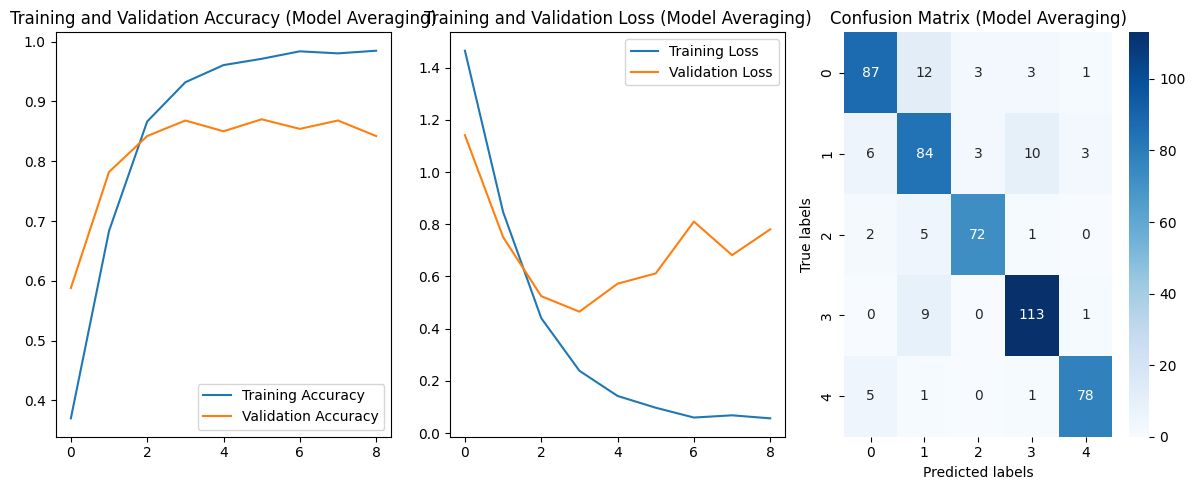

In [122]:
acc = histAve.history['accuracy']
val_acc = histAve.history['val_accuracy']
loss = histAve.history['loss']
val_loss = histAve.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Model Averaging)')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Model Averaging)')


y_predAve = np.argmax(modelAve.predict(X_val_padded), axis=1)
cm = confusion_matrix(y_val, y_predAve)
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Model Averaging)')

plt.tight_layout()
plt.show()

In [123]:
modelSum = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)
    ),
    tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
    Lambda(lambda x: tf.reduce_sum(x, axis=1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
modelSum.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(modelSum.summary())


histSum = modelSum.fit(
    X_train_padded,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_padded, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 33, 300)           2317500   
                                                                 
 bidirectional_26 (Bidirect  (None, 33, 128)           186880    
 ional)                                                          
                                                                 
 lstm_63 (LSTM)              (None, 33, 64)            49408     
                                                                 
 lambda_8 (Lambda)           (None, 64)                0         
                                                                 
 batch_normalization_31 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_62 (Dense)            (None, 5)               

16/16 [==============================] - 0s 14ms/step


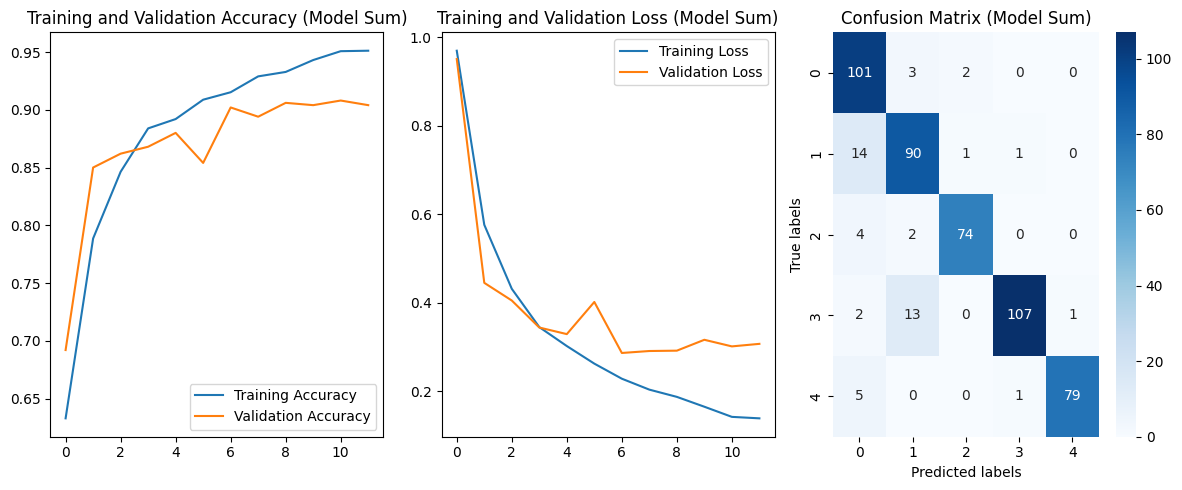

In [124]:
acc = histSum.history['accuracy']
val_acc = histSum.history['val_accuracy']
loss = histSum.history['loss']
val_loss = histSum.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Model Sum)')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Model Sum)')


y_predSum = np.argmax(modelSum.predict(X_val_padded), axis=1)
cm = confusion_matrix(y_val, y_predSum)
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Model Sum)')

plt.tight_layout()
plt.show()

In [125]:
modelMaxPool = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)
    ),
    tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(hidden_units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
modelMaxPool.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(modelMaxPool.summary())


histMaxPool = modelMaxPool.fit(
    X_train_padded,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_padded, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 33, 300)           2317500   
                                                                 
 bidirectional_27 (Bidirect  (None, 33, 128)           186880    
 ional)                                                          
                                                                 
 lstm_65 (LSTM)              (None, 33, 64)            49408     
                                                                 
 global_max_pooling1d_16 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_63 (Dense)            (None, 64)                4160      
                                                                 
 dropout_39 (Dropout)        (None, 64)              

16/16 [==============================] - 0s 11ms/step


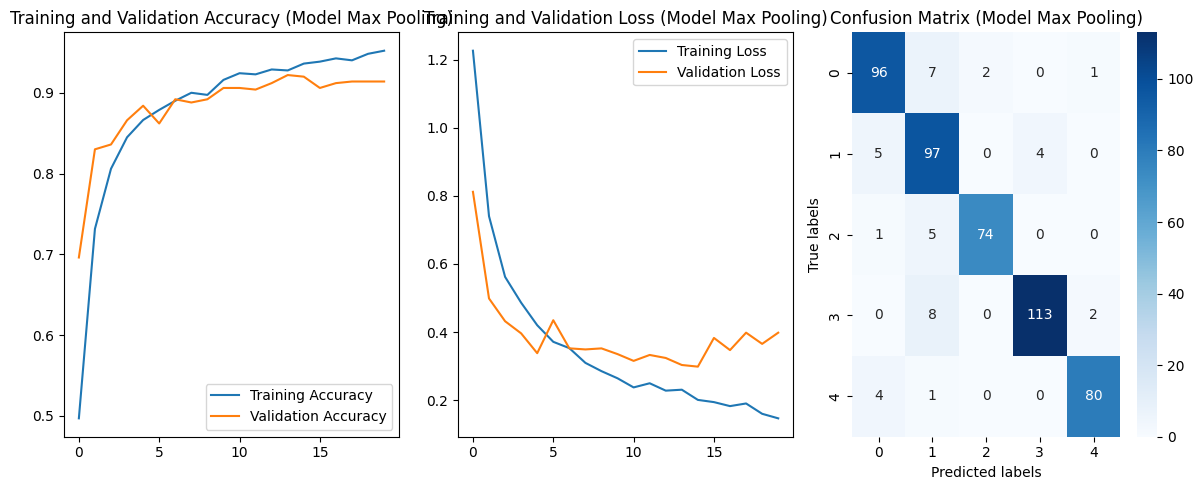

In [126]:
acc = histMaxPool.history['accuracy']
val_acc = histMaxPool.history['val_accuracy']
loss = histMaxPool.history['loss']
val_loss = histMaxPool.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Model Max Pooling)')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Model Max Pooling)')


y_predMaxPool = np.argmax(modelMaxPool.predict(X_val_padded), axis=1)
cm = confusion_matrix(y_val, y_predMaxPool)
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Model Max Pooling)')

plt.tight_layout()
plt.show()

In [133]:
_, accuracy = model2.evaluate(X_test_padded, y_test)
print(f"Test Accuracy (Model Averaging): {accuracy*100:.2f}%")

f1_micro = f1_score(y_val, y_pred2, average='micro')
print(f"f1_score (Model Averaging): {f1_micro:.4f}\n")

_, accuracy = modelAve.evaluate(X_test_padded, y_test)
print(f"Test Accuracy (Model Averaging): {accuracy*100:.2f}%")

f1_micro = f1_score(y_val, y_predAve, average='micro')
print(f"f1_score (Model Averaging): {f1_micro:.4f}\n")

_, accuracy = modelSum.evaluate(X_test_padded, y_test)
print(f"Test Accuracy (Model Sum): {accuracy*100:.2f}%")

f1_micro = f1_score(y_val, y_predSum, average='micro')
print(f"f1_score (Model Sum): {f1_micro:.4f}\n")

_, accuracy = modelMaxPool.evaluate(X_test_padded, y_test)
print(f"Test Accuracy (Model Max Pooling): {accuracy*100:.2f}%")

f1_micro = f1_score(y_val, y_predMaxPool, average='micro')
print(f"f1_score (Model Max Pooling): {f1_micro:.4f}")

16/16 [==============================] - 0s 14ms/step - loss: 0.5843 - accuracy: 0.8160
Test Accuracy (Model Averaging): 81.60%
f1_score (Model Averaging): 0.8300

16/16 [==============================] - 0s 14ms/step - loss: 0.4444 - accuracy: 0.8680
Test Accuracy (Model Averaging): 86.80%
f1_score (Model Averaging): 0.8680

16/16 [==============================] - 0s 14ms/step - loss: 0.3059 - accuracy: 0.9060
Test Accuracy (Model Sum): 90.60%
f1_score (Model Sum): 0.9020

16/16 [==============================] - 0s 16ms/step - loss: 0.3451 - accuracy: 0.9220
Test Accuracy (Model Max Pooling): 92.20%
f1_score (Model Max Pooling): 0.9200


In [139]:
print('''
Question 2
(a) The five classes used are '0', '1', '3', '4' and 'OTHERS', where 'OTHERS' is a combination of '2' and '5'.

(b) The aggregation method to use would be Max Pooling as it has the highest test accuracy and F1 score.
    In a real-world scenario, if the cost of false positives or false negatives are high, Max Pooling which
    has the highest F1 score should be used, where it is more effective at classifying true positives and
    true negatives.

(c) We used a Bidirectional LSTM with 64 hidden units, with a dropout rate of 0.5.

(d) A total of 50 epochs were used for training implemented with early stopping. The total training time is
    less than 4 minutes.

(e) The test set accuracy reached 92.20% and the corresponding F1 score of 0.9200.
      
''')


Question 2
(a) The five classes used are '0', '1', '3', '4' and 'OTHERS', where 'OTHERS' is a combination of '2' and '5'.

(b) The aggregation method to use would be Max Pooling as it has the highest test accuracy and F1 score.
    In a real-world scenario, if the cost of false positives or false negatives are high, Max Pooling which
    has the highest F1 score should be used, where it is more effective at classifying true positives and
    true negatives.

(c) We used a Bidirectional LSTM with 64 hidden units, with a dropout rate of 0.5.

(d) A total of 50 epochs were used for training implemented with early stopping. The total training time is
    less than 4 minutes.

(e) The test set accuracy reached 92.20% and the corresponding F1 score of 0.9200.
      

